# Dependencies

In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup,
    DataCollatorForSeq2Seq
)
from tqdm.auto import tqdm
import numpy as np
import random
import os
import json
from datetime import datetime
import gc

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

2025-12-22 02:28:53.559173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766370533.749297      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766370533.804335      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766370534.256046      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766370534.256087      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766370534.256090      55 computation_placer.cc:177] computation placer alr

# 1. Load training data

In [9]:
MAX_TRAIN_LEN = 150_000

def load_data(en_path, vi_path):
    """Load parallel data from files"""
    with open(en_path, 'r', encoding='utf-8') as f:
        en_lines = [line.strip() for line in f.readlines()]
        en_lines = en_lines[:MAX_TRAIN_LEN]
    
    with open(vi_path, 'r', encoding='utf-8') as f:
        vi_lines = [line.strip() for line in f.readlines()]
        vi_lines = vi_lines[:MAX_TRAIN_LEN]
    
    # Ensure same length
    min_len = min(len(en_lines), len(vi_lines))
    en_lines = en_lines[:min_len]
    vi_lines = vi_lines[:min_len]
    
    # Filter empty lines
    data = [(en, vi) for en, vi in zip(en_lines, vi_lines) 
            if en.strip() and vi.strip()]
    
    print(f"✅ Loaded {len(data)} parallel sentences")
    return data

# Load datasets
print("\n📂 Loading training data...")
train_ds = load_data("/kaggle/input/vlsp-2025-data/train.en.txt",
                     "/kaggle/input/vlsp-2025-data/train.vi.txt")

print("\n📂 Loading test data...")
test_ds = load_data("/kaggle/input/vlsp-2025-data/public_test.en.txt",
                    "/kaggle/input/vlsp-2025-data/public_test.vi.txt")

print(f"\n📊 Dataset sizes:")
print(f"   Training: {len(train_ds):,} pairs")
print(f"   Test: {len(test_ds):,} pairs")


📂 Loading training data...
✅ Loaded 150000 parallel sentences

📂 Loading test data...
✅ Loaded 3000 parallel sentences

📊 Dataset sizes:
   Training: 150,000 pairs
   Test: 3,000 pairs


In [ ]:
class BidirectionalTranslationDataset(Dataset):
    """Dataset that generates both EN->VI and VI->EN samples"""
    
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        # Each pair generates 2 samples (EN->VI and VI->EN)
        return len(self.data) * 2
    
    def __getitem__(self, idx):
        pair_idx = idx // 2
        is_en_to_vi = (idx % 2 == 0)
        
        en_text, vi_text = self.data[pair_idx]
        
        if is_en_to_vi:
            source = "en: " + en_text
            target = vi_text
        else:
            source = "vi: " + vi_text
            target = en_text
        
        # Tokenize
        source_encoding = self.tokenizer(
            source,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        target_encoding = self.tokenizer(
            target,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Prepare labels (replace padding token id with -100)
        labels = target_encoding['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': source_encoding['input_ids'].squeeze(),
            'attention_mask': source_encoding['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

# 2. Load pre-trained model

In [7]:
model_name = "VietAI/envit5-translation"
print(f"\n🤖 Loading model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Setup for multi-GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f"🚀 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)
model.to(device)

print(f"✅ Model loaded on {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")


🤖 Loading model: VietAI/envit5-translation


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

🚀 Using 2 GPUs with DataParallel
✅ Model loaded on cuda
📊 Total parameters: 275,102,976
📊 Trainable parameters: 275,102,976


In [ ]:
config = {
    'batch_size': 32,          
    'num_epochs': 1,          
    'learning_rate': 2e-4,     
    'warmup_ratio': 0.05,       # 10% warmup
    'max_length': 128,
    'gradient_accumulation_steps': 2,  
    'max_grad_norm': 1.0,
    'save_steps': 1000,      
    'eval_steps': 2000,      
    'logging_steps': 100,      
    'output_dir': './envit5_bidirectional_checkpoints',
    'best_model_dir': './envit5_best_model'
}

# Create output directories
os.makedirs(config['output_dir'], exist_ok=True)
os.makedirs(config['best_model_dir'], exist_ok=True)

# Save config
with open(os.path.join(config['output_dir'], 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print("⚙️  Training Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

⚙️  Training Configuration:
   batch_size: 32
   num_epochs: 1
   learning_rate: 0.0002
   warmup_ratio: 0.05
   max_length: 128
   gradient_accumulation_steps: 2
   max_grad_norm: 1.0
   save_steps: 1000
   eval_steps: 2000
   logging_steps: 100
   output_dir: ./envit5_bidirectional_checkpoints
   best_model_dir: ./envit5_best_model


In [10]:
print("\n📦 Creating datasets and dataloaders...")

train_dataset = BidirectionalTranslationDataset(train_ds, tokenizer, config['max_length'])
test_dataset = BidirectionalTranslationDataset(test_ds, tokenizer, config['max_length'])

# Data collator (handles padding dynamically)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=data_collator
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=data_collator
)

print(f"✅ Training batches: {len(train_loader)}")
print(f"✅ Test batches: {len(test_loader)}")
print(f"✅ Training samples (with both directions): {len(train_dataset)}")
print(f"✅ Test samples (with both directions): {len(test_dataset)}")


📦 Creating datasets and dataloaders...
✅ Training batches: 9375
✅ Test batches: 188
✅ Training samples (with both directions): 300000
✅ Test samples (with both directions): 6000


## Optimizers

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

# Calculate total training steps
total_steps = len(train_loader) * config['num_epochs'] // config['gradient_accumulation_steps']
warmup_steps = int(total_steps * config['warmup_ratio'])

# Learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"📈 Total training steps: {total_steps:,}")
print(f"🔥 Warmup steps: {warmup_steps:,}")
print(f"✅ Optimizer and scheduler ready")

📈 Total training steps: 4,687
🔥 Warmup steps: 234
✅ Optimizer and scheduler ready


In [ ]:
import sacrebleu

def evaluate_with_metrics(model, dataloader, tokenizer, device, num_samples=500):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    # For BLEU calculation
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass for loss
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            if isinstance(model, nn.DataParallel):
                loss = loss.mean()  # Average across GPUs
            
            total_loss += loss.item()
            num_batches += 1
            
            # Generate translations for BLEU (only first num_samples)
            if len(predictions) < num_samples:
                model_to_use = model.module if isinstance(model, nn.DataParallel) else model
                generated = model_to_use.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=128,
                    num_beams=4,
                    early_stopping=True
                )
                
                # Decode predictions
                batch_preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
                predictions.extend(batch_preds)
                
                # Decode references
                labels_copy = labels.clone()
                labels_copy[labels_copy == -100] = tokenizer.pad_token_id
                batch_refs = tokenizer.batch_decode(labels_copy, skip_special_tokens=True)
                references.extend(batch_refs)
            
            if len(predictions) >= num_samples:
                break
    
    # Calculate metrics
    avg_loss = total_loss / num_batches
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    
    # Calculate BLEU
    predictions = predictions[:num_samples]
    references = references[:num_samples]
    bleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
    
    return {
        'loss': avg_loss,
        'perplexity': perplexity,
        'bleu': bleu_score
    }

In [16]:
def save_checkpoint(model, optimizer, scheduler, epoch, step, loss, save_dir):
    """Save training checkpoint"""
    os.makedirs(save_dir, exist_ok=True)
    
    checkpoint = {
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'config': config
    }
    
    checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch{epoch}_step{step}.pt')
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")
    
    return checkpoint_path

def save_best_model(model, tokenizer, save_dir, val_loss):
    """Save best model"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_to_save = model.module if isinstance(model, nn.DataParallel) else model
    model_to_save.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    
    # Save metadata
    metadata = {
        'val_loss': val_loss,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"🏆 Best model saved to: {save_dir}")

# 3. Training

In [ ]:
best_val_loss = float('inf')
global_step = 0
training_logs = []
evaluation_history = []  

# Training loop
for epoch in range(config['num_epochs']):
    print(f"\n{'='*70}")
    print(f"📅 EPOCH {epoch + 1}/{config['num_epochs']}")
    print(f"{'='*70}\n")
    
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    
    for step, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        
        if isinstance(model, nn.DataParallel):
            loss = loss.mean()
        
        loss = loss / config['gradient_accumulation_steps']
        loss.backward()
        
        epoch_loss += loss.item()
        
        # Update weights
        if (step + 1) % config['gradient_accumulation_steps'] == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1
            
            # Update progress bar
            current_lr = scheduler.get_last_lr()[0]
            progress_bar.set_postfix({
                'loss': f"{loss.item() * config['gradient_accumulation_steps']:.4f}",
                'lr': f"{current_lr:.2e}"
            })
            
            # Logging
            if global_step % config['logging_steps'] == 0:
                log_entry = {
                    'epoch': epoch + 1,
                    'step': global_step,
                    'train_loss': loss.item() * config['gradient_accumulation_steps'],
                    'learning_rate': current_lr
                }
                training_logs.append(log_entry)
                
                # Save logs
                with open(os.path.join(config['output_dir'], 'training_logs.json'), 'w') as f:
                    json.dump(training_logs, f, indent=2)
            
            # Evaluation with full metrics
            if global_step % config['eval_steps'] == 0:
                print(f"\n\n📊 Evaluating at step {global_step}...")
                eval_metrics = evaluate_with_metrics(model, test_loader, tokenizer, device)
                
                val_loss = eval_metrics['loss']
                val_ppl = eval_metrics['perplexity']
                val_bleu = eval_metrics['bleu']
                
                print(f"   Validation Loss: {val_loss:.4f}")
                print(f"   Validation Perplexity: {val_ppl:.2f}")
                print(f"   Validation BLEU: {val_bleu:.2f}\n")
                
                # Save evaluation metrics
                eval_entry = {
                    'epoch': epoch + 1,
                    'step': global_step,
                    'val_loss': val_loss,
                    'val_perplexity': val_ppl,
                    'val_bleu': val_bleu,
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }
                evaluation_history.append(eval_entry)
                
                # Save evaluation history
                with open(os.path.join(config['output_dir'], 'evaluation_history.json'), 'w') as f:
                    json.dump(evaluation_history, f, indent=2)
                
                # Save best model
                if val_loss < best_val_loss:
                    print(f"🎉 New best validation loss: {val_loss:.4f} (previous: {best_val_loss:.4f})")
                    best_val_loss = val_loss
                    save_best_model(model, tokenizer, config['best_model_dir'], val_loss)
                
                model.train()
            
            # Save checkpoint
            if global_step % config['save_steps'] == 0:
                checkpoint_dir = os.path.join(config['output_dir'], f'checkpoint-{global_step}')
                save_checkpoint(model, optimizer, scheduler, epoch, global_step, 
                              loss.item(), checkpoint_dir)
                
                # Clean up old checkpoints (keep last 3)
                checkpoints = sorted([d for d in os.listdir(config['output_dir']) 
                                    if d.startswith('checkpoint-')])
                if len(checkpoints) > 3:
                    for old_ckpt in checkpoints[:-3]:
                        import shutil
                        shutil.rmtree(os.path.join(config['output_dir'], old_ckpt))
                        print(f"🗑️  Removed old checkpoint: {old_ckpt}")
        
        # Memory cleanup
        if step % 100 == 0:
            torch.cuda.empty_cache()
    
    # End of epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"\n📊 Epoch {epoch + 1} completed!")
    print(f"   Average Loss: {avg_epoch_loss:.4f}")
    
    # Evaluate at end of epoch with full metrics
    print(f"\n📊 Final evaluation for epoch {epoch + 1}...")
    eval_metrics = evaluate_with_metrics(model, test_loader, tokenizer, device)
    
    val_loss = eval_metrics['loss']
    val_ppl = eval_metrics['perplexity']
    val_bleu = eval_metrics['bleu']
    
    print(f"   Validation Loss: {val_loss:.4f}")
    print(f"   Validation Perplexity: {val_ppl:.2f}")
    print(f"   Validation BLEU: {val_bleu:.2f}")
    
    # Save end-of-epoch metrics
    eval_entry = {
        'epoch': epoch + 1,
        'step': global_step,
        'val_loss': val_loss,
        'val_perplexity': val_ppl,
        'val_bleu': val_bleu,
        'end_of_epoch': True,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    evaluation_history.append(eval_entry)
    
    with open(os.path.join(config['output_dir'], 'evaluation_history.json'), 'w') as f:
        json.dump(evaluation_history, f, indent=2)
    
    # Save epoch checkpoint
    epoch_checkpoint_dir = os.path.join(config['output_dir'], f'epoch-{epoch+1}')
    save_checkpoint(model, optimizer, scheduler, epoch+1, global_step, 
                   val_loss, epoch_checkpoint_dir)
    
    # Check if best model
    if val_loss < best_val_loss:
        print(f"🎉 New best validation loss: {val_loss:.4f}")
        best_val_loss = val_loss
        save_best_model(model, tokenizer, config['best_model_dir'], val_loss)

print("\n" + "="*70)
print("✅ TRAINING COMPLETED!")
print("="*70)
print(f"🏆 Best validation loss: {best_val_loss:.4f}")
print(f"💾 Best model saved to: {config['best_model_dir']}")
print(f"📂 Checkpoints saved to: {config['output_dir']}")
print(f"📊 Evaluation history saved to: {os.path.join(config['output_dir'], 'evaluation_history.json')}")


📅 EPOCH 1/1



Training Epoch 1:   0%|          | 0/9375 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please conside

💾 Checkpoint saved: ./envit5_bidirectional_checkpoints/checkpoint-1000/checkpoint_epoch0_step1000.pt


📊 Evaluating at step 2000...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please conside

   Validation Loss: 0.9406
   Validation Perplexity: 2.56
   Validation BLEU: 44.91

🎉 New best validation loss: 0.9406 (previous: inf)
🏆 Best model saved to: ./envit5_best_model
💾 Checkpoint saved: ./envit5_bidirectional_checkpoints/checkpoint-2000/checkpoint_epoch0_step2000.pt
💾 Checkpoint saved: ./envit5_bidirectional_checkpoints/checkpoint-3000/checkpoint_epoch0_step3000.pt


📊 Evaluating at step 4000...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please conside

   Validation Loss: 0.8740
   Validation Perplexity: 2.40
   Validation BLEU: 46.94

🎉 New best validation loss: 0.8740 (previous: 0.9406)
🏆 Best model saved to: ./envit5_best_model
💾 Checkpoint saved: ./envit5_bidirectional_checkpoints/checkpoint-4000/checkpoint_epoch0_step4000.pt
🗑️  Removed old checkpoint: checkpoint-1000

📊 Epoch 1 completed!
   Average Loss: 0.6453

📊 Final evaluation for epoch 1...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please conside

   Validation Loss: 0.8636
   Validation Perplexity: 2.37
   Validation BLEU: 47.16
💾 Checkpoint saved: ./envit5_bidirectional_checkpoints/epoch-1/checkpoint_epoch1_step4687.pt
🎉 New best validation loss: 0.8636
🏆 Best model saved to: ./envit5_best_model

✅ TRAINING COMPLETED!
🏆 Best validation loss: 0.8636
💾 Best model saved to: ./envit5_best_model
📂 Checkpoints saved to: ./envit5_bidirectional_checkpoints
📊 Evaluation history saved to: ./envit5_bidirectional_checkpoints/evaluation_history.json


In [18]:
final_model_dir = './envit5_final_model'
os.makedirs(final_model_dir, exist_ok=True)

model_to_save = model.module if isinstance(model, nn.DataParallel) else model
model_to_save.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

print(f"\n💾 Final model saved to: {final_model_dir}")

# Save final training summary
summary = {
    'best_val_loss': best_val_loss,
    'total_steps': global_step,
    'total_epochs': config['num_epochs'],
    'training_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(config['output_dir'], 'training_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"📊 Training summary saved")
print(f"\n{'='*70}")
print("🎉 ALL DONE! Your bidirectional model is ready to use!")
print(f"{'='*70}")


💾 Final model saved to: ./envit5_final_model
📊 Training summary saved

🎉 ALL DONE! Your bidirectional model is ready to use!


In [19]:
print("\n🧪 Testing inference on both directions...\n")

# Load best model for testing
best_model = AutoModelForSeq2SeqLM.from_pretrained(config['best_model_dir']).to(device)
best_tokenizer = AutoTokenizer.from_pretrained(config['best_model_dir'])

def translate(text, direction="en2vi", model=best_model, tokenizer=best_tokenizer):
    """Translate text in specified direction"""
    # Add prefix based on direction
    if direction.lower() in ["en2vi", "en->vi"]:
        input_text = "en: " + text
    else:
        input_text = "vi: " + text
    
    # Tokenize
    inputs = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=128,
            num_beams=5,
            early_stopping=True
        )
    
    # Decode
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translation

# Test examples
test_examples = {
    'en': "In Hindu mythology, Jatayu was the vulture god, and he risked his life in order to save the goddess Sita from the 10-headed demon Ravana.486",
    'vi': "Mục đích của nghiên cứu này là đánh giá tác dụng giảm cân và hạ lipid máu trên chuột nhắt trắng béo phì bằng hỗn hợp dung môi C. chắp và G. pentura trên chuột nhắt trắng béo phì",
    'en': "The purpose of this study was to evaluate the effects of a mixture731 extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice"
}

print("🔄 EN -> VI:")
print(f"   Input:  {test_examples['en']}")
print(f"   Output: {translate(test_examples['en'], 'en2vi')}")

print("\n🔄 VI -> EN:")
print(f"   Input:  {test_examples['vi']}")
print(f"   Output: {translate(test_examples['vi'], 'vi2en')}")

print("\n✅ Inference test completed!")


🧪 Testing inference on both directions...

🔄 EN -> VI:
   Input:  The purpose of this study was to evaluate the effects of a mixture731 extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice
   Output: Mục tiêu của nghiên cứu này là đánh giá tác dụng giảm cân và hạ lipid máu của cao chiết 731 loài C. chrysantha và G. pentaphyllum trên chuột Swiss béo phì.

🔄 VI -> EN:
   Input:  Mục đích của nghiên cứu này là đánh giá tác dụng giảm cân và hạ lipid máu trên chuột nhắt trắng béo phì bằng hỗn hợp dung môi C. chắp và G. pentura trên chuột nhắt trắng béo phì
   Output: The purpose of this study was to evaluate the effect of weight loss and hypolipidemic in obese mice by the mixture of C pentura and G pentura solvents on obese mice.

✅ Inference test completed!


# Plotting

📊 Generating training metrics plots...



/tmp/ipykernel_55/1657089514.py:155: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(output_dir, 'training_metrics.png'),
/tmp/ipykernel_55/1657089514.py:155: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(output_dir, 'training_metrics.png'),
/tmp/ipykernel_55/1657089514.py:155: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(output_dir, 'training_metrics.png'),
/tmp/ipykernel_55/1657089514.py:155: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(output_dir, 'training_metrics.png'),
/tmp/ipykernel_55/1657089514.py:155: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(output_dir, 'training_metrics.png'),
/tmp/ipykernel_55/1657089514.py:155: UserWarning: Glyph 127

📊 Plot saved to: ./envit5_bidirectional_checkpoints/training_metrics.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, 

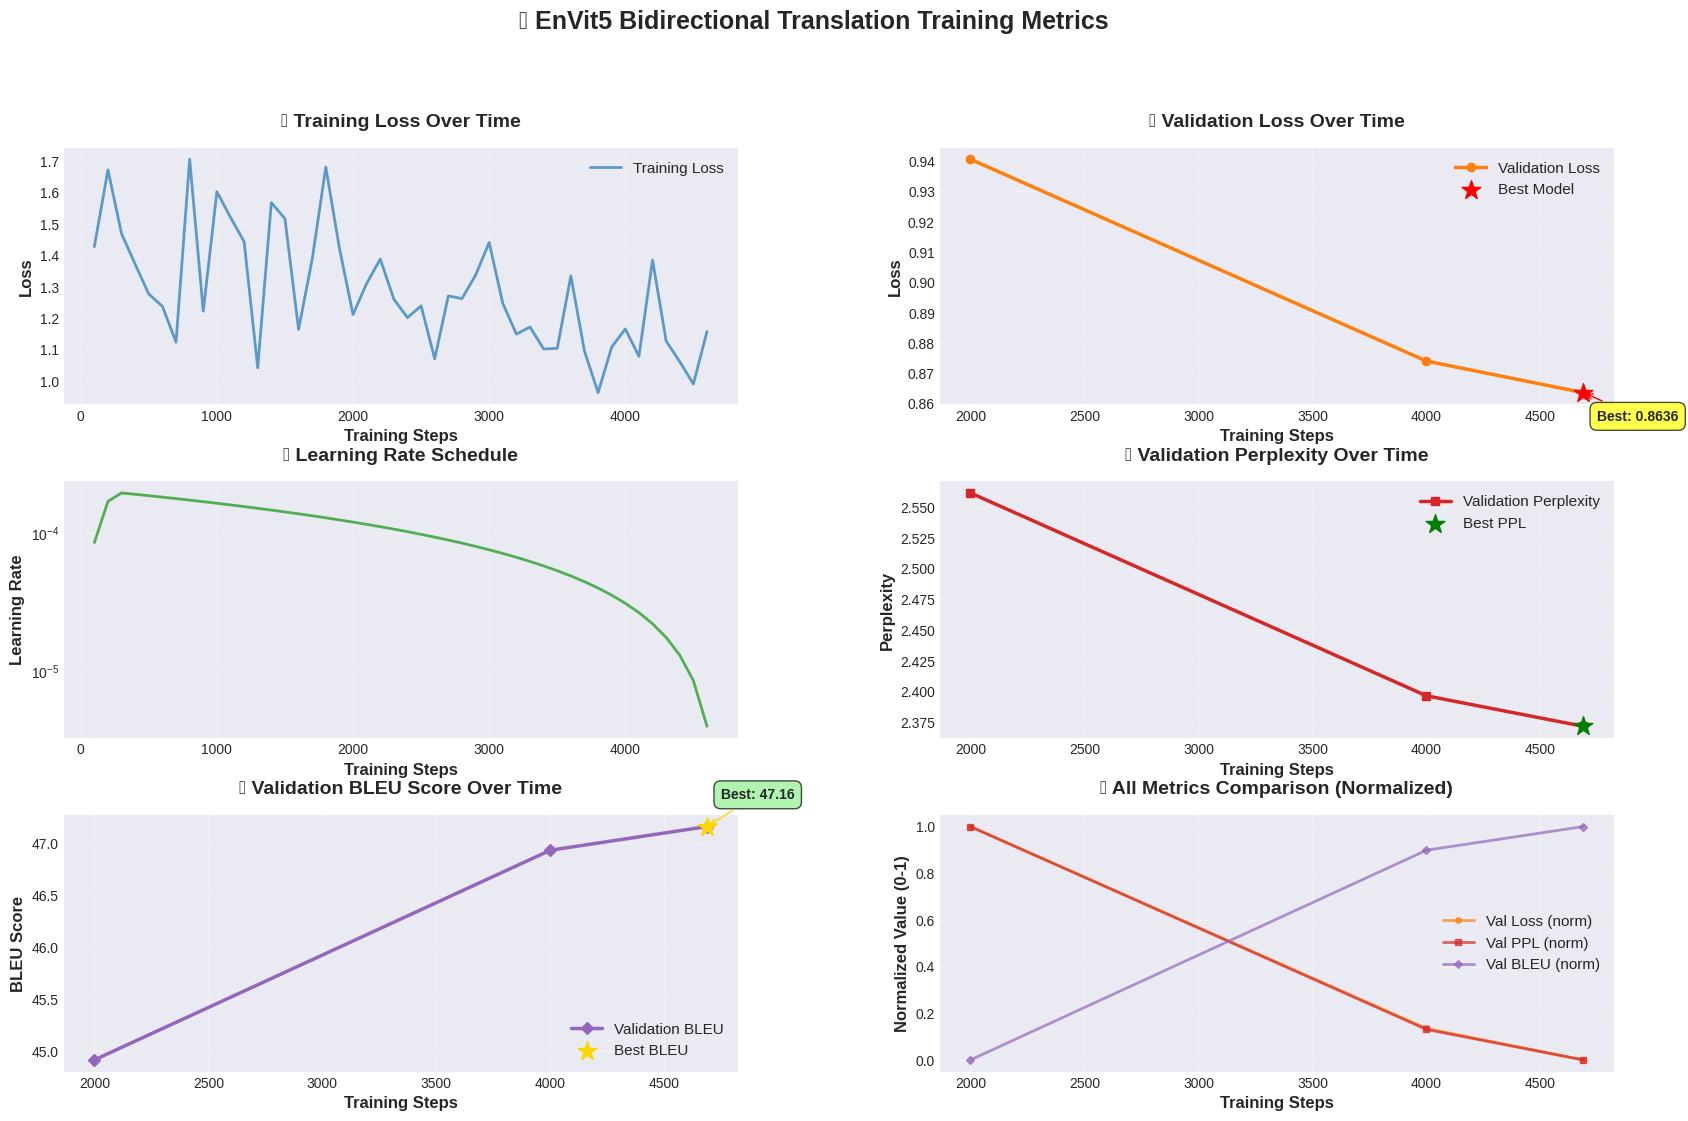


📈 TRAINING SUMMARY STATISTICS

🎯 Best Validation Loss: 0.8636 (at step 4687)
🎯 Best Validation Perplexity: 2.37 (at step 4687)
🎯 Best Validation BLEU: 47.16 (at step 4687)

📉 Final Training Loss: 1.1572
📉 Final Validation Loss: 0.8636
📉 Final Validation Perplexity: 2.37
📉 Final Validation BLEU: 47.16

📊 Total Training Steps: 4,600
📊 Total Evaluations: 3



In [20]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

def plot_training_metrics(output_dir='./envit5_bidirectional_checkpoints'):
    """Plot comprehensive training metrics"""
    
    # Load data
    with open(os.path.join(output_dir, 'training_logs.json'), 'r') as f:
        training_logs = json.load(f)
    
    with open(os.path.join(output_dir, 'evaluation_history.json'), 'r') as f:
        eval_history = json.load(f)
    
    # Extract data
    train_steps = [log['step'] for log in training_logs]
    train_losses = [log['train_loss'] for log in training_logs]
    learning_rates = [log['learning_rate'] for log in training_logs]
    
    eval_steps = [eval['step'] for eval in eval_history]
    val_losses = [eval['val_loss'] for eval in eval_history]
    val_perplexities = [eval['val_perplexity'] for eval in eval_history]
    val_bleus = [eval['val_bleu'] for eval in eval_history]
    
    # Create figure with custom layout
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # Color scheme
    colors = {
        'train': '#1f77b4',
        'val': '#ff7f0e',
        'lr': '#2ca02c',
        'ppl': '#d62728',
        'bleu': '#9467bd'
    }
    
    # ========== Plot 1: Training Loss ==========
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(train_steps, train_losses, color=colors['train'], linewidth=2, alpha=0.7, label='Training Loss')
    ax1.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax1.set_title('📉 Training Loss Over Time', fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # ========== Plot 2: Validation Loss ==========
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(eval_steps, val_losses, color=colors['val'], linewidth=2.5, marker='o', 
             markersize=6, label='Validation Loss')
    
    # Mark best point
    best_idx = val_losses.index(min(val_losses))
    ax2.scatter([eval_steps[best_idx]], [val_losses[best_idx]], 
               color='red', s=200, zorder=5, marker='*', label='Best Model')
    ax2.annotate(f'Best: {val_losses[best_idx]:.4f}', 
                xy=(eval_steps[best_idx], val_losses[best_idx]),
                xytext=(10, -20), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))
    
    ax2.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('📊 Validation Loss Over Time', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='upper right', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # ========== Plot 3: Learning Rate Schedule ==========
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(train_steps, learning_rates, color=colors['lr'], linewidth=2, alpha=0.8)
    ax3.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    ax3.set_title('📈 Learning Rate Schedule', fontsize=14, fontweight='bold', pad=15)
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # ========== Plot 4: Validation Perplexity ==========
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(eval_steps, val_perplexities, color=colors['ppl'], linewidth=2.5, 
             marker='s', markersize=6, label='Validation Perplexity')
    
    # Mark best point
    best_ppl_idx = val_perplexities.index(min(val_perplexities))
    ax4.scatter([eval_steps[best_ppl_idx]], [val_perplexities[best_ppl_idx]], 
               color='green', s=200, zorder=5, marker='*', label='Best PPL')
    
    ax4.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
    ax4.set_title('🎯 Validation Perplexity Over Time', fontsize=14, fontweight='bold', pad=15)
    ax4.legend(loc='upper right', fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # ========== Plot 5: Validation BLEU ==========
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.plot(eval_steps, val_bleus, color=colors['bleu'], linewidth=2.5, 
             marker='D', markersize=6, label='Validation BLEU')
    
    # Mark best point
    best_bleu_idx = val_bleus.index(max(val_bleus))
    ax5.scatter([eval_steps[best_bleu_idx]], [val_bleus[best_bleu_idx]], 
               color='gold', s=200, zorder=5, marker='*', label='Best BLEU')
    ax5.annotate(f'Best: {val_bleus[best_bleu_idx]:.2f}', 
                xy=(eval_steps[best_bleu_idx], val_bleus[best_bleu_idx]),
                xytext=(10, 20), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='gold'))
    
    ax5.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax5.set_ylabel('BLEU Score', fontsize=12, fontweight='bold')
    ax5.set_title('🌟 Validation BLEU Score Over Time', fontsize=14, fontweight='bold', pad=15)
    ax5.legend(loc='lower right', fontsize=11)
    ax5.grid(True, alpha=0.3)
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    
    # ========== Plot 6: Combined Metrics (Normalized) ==========
    ax6 = fig.add_subplot(gs[2, 1])
    
    # Normalize metrics to 0-1 scale for comparison
    norm_loss = [(l - min(val_losses)) / (max(val_losses) - min(val_losses)) for l in val_losses]
    norm_ppl = [(p - min(val_perplexities)) / (max(val_perplexities) - min(val_perplexities)) for p in val_perplexities]
    norm_bleu = [(b - min(val_bleus)) / (max(val_bleus) - min(val_bleus)) for b in val_bleus]
    
    ax6.plot(eval_steps, norm_loss, color=colors['val'], linewidth=2, 
             marker='o', markersize=4, label='Val Loss (norm)', alpha=0.7)
    ax6.plot(eval_steps, norm_ppl, color=colors['ppl'], linewidth=2, 
             marker='s', markersize=4, label='Val PPL (norm)', alpha=0.7)
    ax6.plot(eval_steps, norm_bleu, color=colors['bleu'], linewidth=2, 
             marker='D', markersize=4, label='Val BLEU (norm)', alpha=0.7)
    
    ax6.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Normalized Value (0-1)', fontsize=12, fontweight='bold')
    ax6.set_title('📊 All Metrics Comparison (Normalized)', fontsize=14, fontweight='bold', pad=15)
    ax6.legend(loc='best', fontsize=11)
    ax6.grid(True, alpha=0.3)
    ax6.spines['top'].set_visible(False)
    ax6.spines['right'].set_visible(False)
    
    # Add main title
    fig.suptitle('🎓 EnVit5 Bidirectional Translation Training Metrics', 
                fontsize=18, fontweight='bold', y=0.995)
    
    # Save figure
    plt.savefig(os.path.join(output_dir, 'training_metrics.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    print(f"📊 Plot saved to: {os.path.join(output_dir, 'training_metrics.png')}")
    
    plt.show()
    
    # ========== Print Summary Statistics ==========
    print("\n" + "="*70)
    print("📈 TRAINING SUMMARY STATISTICS")
    print("="*70)
    print(f"\n🎯 Best Validation Loss: {min(val_losses):.4f} (at step {eval_steps[best_idx]})")
    print(f"🎯 Best Validation Perplexity: {min(val_perplexities):.2f} (at step {eval_steps[best_ppl_idx]})")
    print(f"🎯 Best Validation BLEU: {max(val_bleus):.2f} (at step {eval_steps[best_bleu_idx]})")
    print(f"\n📉 Final Training Loss: {train_losses[-1]:.4f}")
    print(f"📉 Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"📉 Final Validation Perplexity: {val_perplexities[-1]:.2f}")
    print(f"📉 Final Validation BLEU: {val_bleus[-1]:.2f}")
    print(f"\n📊 Total Training Steps: {train_steps[-1]:,}")
    print(f"📊 Total Evaluations: {len(eval_steps)}")
    print("="*70 + "\n")

# Run the plotting function
print("📊 Generating training metrics plots...\n")
plot_training_metrics()